# Internal Resistance Calculation for Small Vertical Axis Wind Turbine
**Author:** Ian Eykamp, **Date:** 6/16/2023

## Purpose
I powered the wind turbine using the wind tunnel in the 4th floor Rocketry lab. I repeated calculations used to find the internal resistance of the generator.

The wind tunnel has a power setting from 0-80 that corresponds to how fast (in Hz) the fan inside the wind tunnel is spinning. So it doesn't really correlate with an actual wind speed felt by the turbine. There is a table that correlates the speed setting to wind speed, but this means wind speed inside the tunnel, which is different and much lower at the outlet, especially as it diffuses into the open space. The first set of measurements is taken at a setting of 20 out of 80; for the later measurements, I set it to either 30 or 39 out of 80, because that was as fast as I felt comfortable letting the wind turbine spin safely.

### Import libraries
`plecs_helper.py` is a file I created which defines some helper functions for nice plots and getting data off the oscilloscope and out of PLECS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

Using matplotlib backend: <object object at 0x000001B7BE57D580>


C:\Users\ieykamp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import Data
I connected the oscilloscope leads between two terminals of the generator (the third terminal was left dangling). I set the oscilloscope up with 2V/division (y axis) and 5s/division (time axis). That way, I got a trace which lasted more than 30 seconds, enough for it to slow down considerably. I used the data density setting of 12k data points, and this was easily able to capture all the peaks. I spun the turbine by hand by giving it a moderate shove. It started spinning with a frequency around 6Hz, and as it slowed down, I was able to capture its frequency and amplitude on the oscilloscope.

I captured one dataset with no load, and three further datasets at 100Ohm, 6.8Ohm, and (6.8 || (6.8 + 6.8)) Ohm loads between the terminals I was measuring.

In [2]:
# Import data
# (df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile1.csv", ch1 = "6.8Ohm_Delta")
(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile2.csv", ch1 = "4.5Ohm")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile3.csv", ch1 = "100Ohm")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile4.csv", ch1 = "6.8Ohm")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile5.csv", ch1 = "unloaded")
# (df_6, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile6.csv", ch1 = "100Ohm_30Hz")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t")]).reset_index()
# print(df.head(20))

### Plot Data
I calculated the frequency by looking at the spacing of the peaks. After smoothing out the frequency and the peak values, I found the location where each trace crossed 4Hz and took the amplitude at that location. Since the amplitude depends on frequency, this is to normalize across datasets, since the turbine is not necsessarily spinning at the same frequency at the same timestamp.

[5.171665580075063]
[5.171665580075063, 4.9418251017030075]
[5.171665580075063, 4.9418251017030075, 4.257293624460329]
[5.171665580075063, 4.9418251017030075, 4.257293624460329, 4.0624595289463095]


C:\Users\ieykamp\AppData\Local\Temp\ipykernel_8848\536022639.py:34: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 100, width = 100)[0]
C:\Users\ieykamp\AppData\Local\Temp\ipykernel_8848\536022639.py:34: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 100, width = 100)[0]


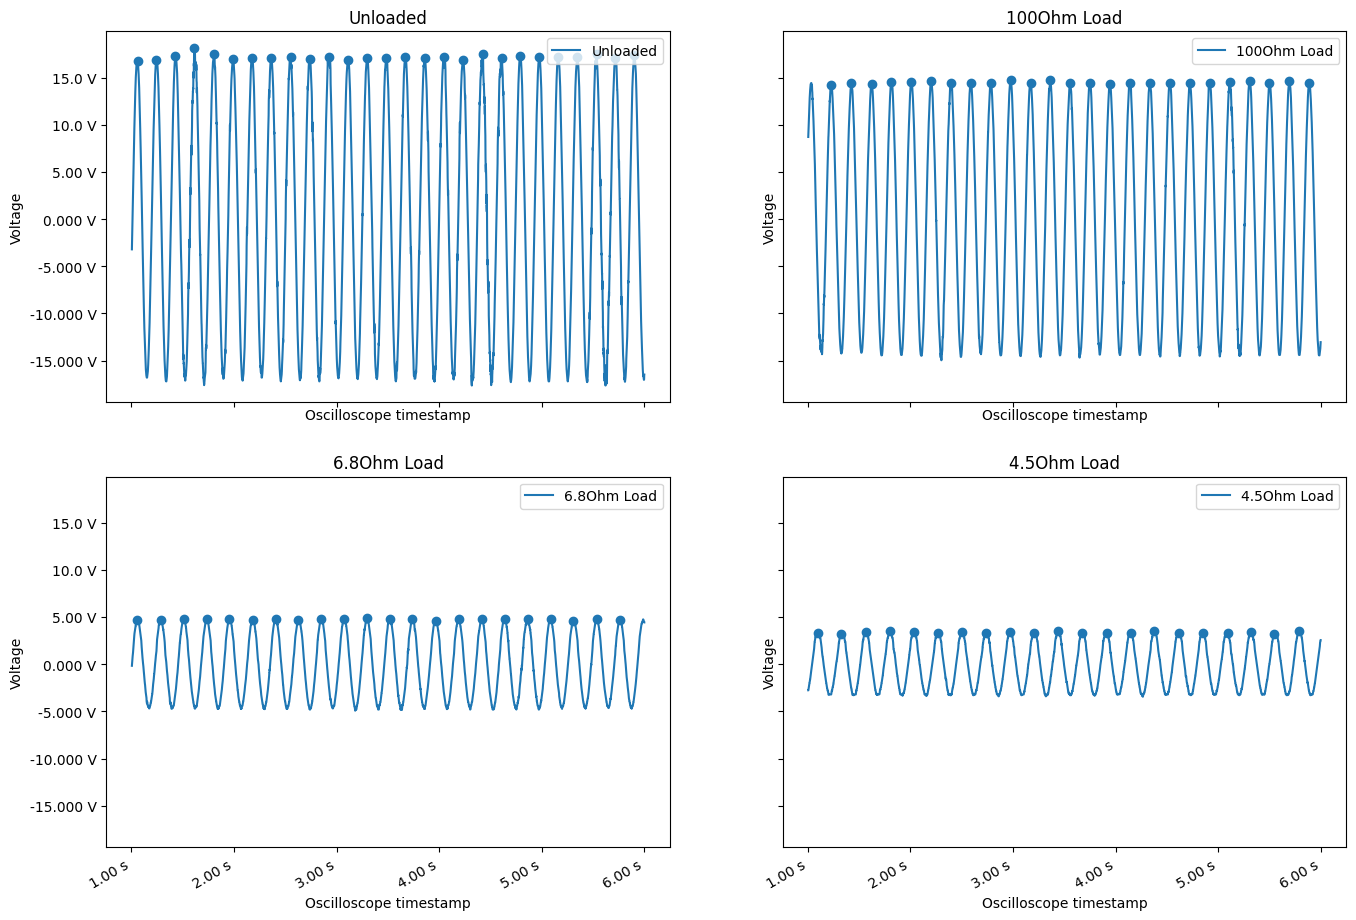

In [3]:
def moving_average(x, w):
    w = int(w / 2) * 2
    convolution = np.convolve(x, np.ones(w), 'full') / w
    return convolution[int(w/2):-int(w/2)+1]

def find_y_crossing_monotonic_decrease(y_vals, y_target):
    left_side_idx = list(np.arange(len(y_vals))[y_vals > y_target])
    return left_side_idx[-1]

def interpolate_outliers(y_vals, outlier_bool):
    outlier_idx = np.nonzero(outlier_bool)[0]
    if len(outlier_idx) == 0:
        return y_vals
    assert(all(np.diff(outlier_idx) > 1))
    assert(all(outlier_idx > 0) and all(outlier_idx < len(y_vals - 1))) # not the first or last element
    for idx in outlier_idx:
        y_vals[idx] = (y_vals[idx - 1] + y_vals[idx + 1]) / 2
    return y_vals

df_zoom = df[(df["t"] > 1) & (df["t"] < 6)]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (16, 12))
fig.autofmt_xdate()

ax_list = [ax1, ax2, ax3, ax4]
channel_list = ["unloaded", "100Ohm", "6.8Ohm", "4.5Ohm"]
label_list = ["Unloaded", "100Ohm Load", "6.8Ohm Load", "4.5Ohm Load"]

frequencies = []
amplitudes = []
for (ax, channel, label) in zip(ax_list, channel_list, label_list):
    helper.axes_labels("Oscilloscope timestamp", "s", "Voltage", "V", title = label, ax = ax)

    # find peaks for frequency and envelope amplitude analysis
    peak_idx = find_peaks(df_zoom[channel], distance = 100, width = 100)[0]
    df_peak_trace = df_zoom.iloc[peak_idx]

    # find frequency using time difference between peaks
    frequency_points = np.hstack((0, 1 / (np.diff(df_peak_trace["t"]))))
    mean_freq = np.mean(frequency_points)
    frequencies.append(mean_freq)
    amplitude_points = df_peak_trace[channel]
    mean_amplitude = np.mean(amplitude_points)
    amplitudes.append(mean_amplitude)

    print(frequencies)

    # plot data with peaks
    ax.plot(df_zoom["t"], df_zoom[channel], label = label)
    ax.scatter(df_peak_trace["t"], df_peak_trace[channel])
    ax.legend(loc = "upper right")

The abrupt drop off in frequency near the end is a figment of the smoothing algorithm and can be ignored.

The amplitudes at 4Hz are as follows. I calcualted the internal resistance $R_1$ using the following equation, based on the load resistor I was using: $R1 = R2 \cdot (\frac{V_{in}}{V_{out}} - 1)$, where $V_{in}$ is the unloaded amplitude and $V_{out}$ is the amplitude given a load resistor of $R_2$. The internal resistance of the generator is approximately $14.5 \Omega \pm 1 \Omega$.

In [4]:
def calculate_R1(Vin, Vout, R2):
    R1 = R2 * (Vin / Vout - 1)
    return R1

print(f"Amplitude with no load at {np.round(frequencies[0], 3)}Hz = {np.round(amplitudes[0], 3) * units.volt}")
print(f"Amplitude with 100Ω load at {np.round(frequencies[1], 3)}Hz = {np.round(amplitudes[1], 3) * units.volt}")
print(f"Amplitude with 6.8Ω load at {np.round(frequencies[2], 3)}Hz = {np.round(amplitudes[2], 3) * units.volt}")
print(f"Amplitude with 4.5Ω load at {np.round(frequencies[3], 3)}Hz = {np.round(amplitudes[3], 3) * units.volt}")
print("")

print("Three different calculations for internal resistance:")
print("R1 =", calculate_R1(amplitudes[0] * units.volt, amplitudes[1] * units.volt * frequencies[0] / frequencies[1], 100 * units.ohm))
print("R1 =", calculate_R1(amplitudes[0] * units.volt, amplitudes[2] * units.volt * frequencies[0] / frequencies[2], 6.8 * units.ohm))
print("R1 =", calculate_R1(amplitudes[0] * units.volt, amplitudes[3] * units.volt * frequencies[0] / frequencies[3], 1/(1/6.8 + 1/(2 * 6.8)) * units.ohm))

Amplitude with no load at 5.172Hz = 17.19 V
Amplitude with 100Ω load at 4.942Hz = 14.49 V
Amplitude with 6.8Ω load at 4.257Hz = 4.76 V
Amplitude with 4.5Ω load at 4.062Hz = 3.38 V

Three different calculations for internal resistance:
R1 = 13.41 Ω
R1 = 13.42 Ω
R1 = 13.61 Ω


C:\Users\ieykamp\AppData\Local\Temp\ipykernel_8848\718095182.py:27: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 50, width = 50)[0]
C:\Users\ieykamp\AppData\Local\Temp\ipykernel_8848\718095182.py:27: PeakPropertyWarning: some peaks have a width of 0
  peak_idx = find_peaks(df_zoom[channel], distance = 50, width = 50)[0]


[10.447231715528314]
[10.447231715528314, 10.743094221045077]
[10.447231715528314, 10.743094221045077, 7.317705734350978]
[10.447231715528314, 10.743094221045077, 7.317705734350978, 8.137063215266435]


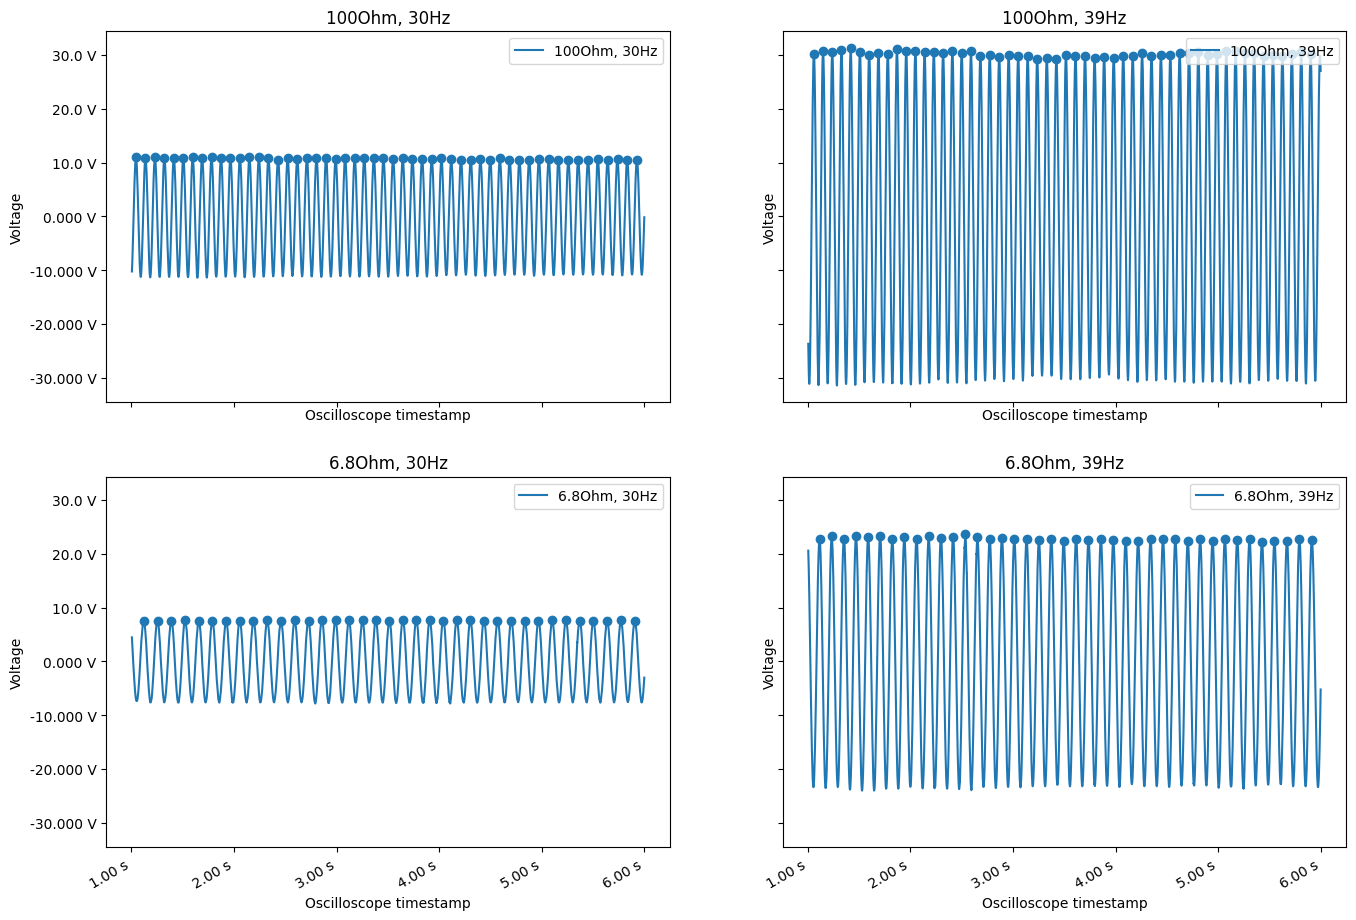

In [5]:
# Import data
# (df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile1.csv", ch1 = "6.8Ohm_Delta")
(df_1, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile1.csv", ch1 = "4.5Ohm")
(df_2, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile2.csv", ch1 = "100Ohm")
(df_3, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile3.csv", ch1 = "6.8Ohm")
(df_4, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/high_speed/Newfile4.csv", ch1 = "unloaded")
# (df_6, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Newfile6.csv", ch1 = "100Ohm_30Hz")

# Combine all variables into one for convenience
df = df_1.set_index("t").join([df_2.set_index("t"), df_3.set_index("t"), df_4.set_index("t")]).reset_index()
# print(df.head(20))

df_zoom = df[(df["t"] > 1) & (df["t"] < 6)]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (16, 12))
fig.autofmt_xdate()

ax_list = [ax1, ax2, ax3, ax4]
channel_list = ["unloaded", "100Ohm", "6.8Ohm", "4.5Ohm"]
label_list = ["100Ohm, 30Hz", "100Ohm, 39Hz", "6.8Ohm, 30Hz", "6.8Ohm, 39Hz"]

frequencies = []
amplitudes = []
for (ax, channel, label) in zip(ax_list, channel_list, label_list):
    helper.axes_labels("Oscilloscope timestamp", "s", "Voltage", "V", title = label, ax = ax)

    # find peaks for frequency and envelope amplitude analysis
    peak_idx = find_peaks(df_zoom[channel], distance = 50, width = 50)[0]
    df_peak_trace = df_zoom.iloc[peak_idx]

    # find frequency using time difference between peaks
    frequency_points = np.hstack((0, 1 / (np.diff(df_peak_trace["t"]))))
    mean_freq = np.mean(frequency_points)
    frequencies.append(mean_freq)
    amplitude_points = df_peak_trace[channel]
    mean_amplitude = np.mean(amplitude_points)
    amplitudes.append(mean_amplitude)

    print(frequencies)

    # plot data with peaks
    ax.plot(df_zoom["t"], df_zoom[channel], label = label)
    ax.scatter(df_peak_trace["t"], df_peak_trace[channel])
    ax.legend(loc = "upper right")